![](img/330-banner.png)

# Lecture 11: Ensembles

UBC 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

<blockquote>
The interests of truth require a diversity of opinions.    
    
by John Stuart Mill
</blockquote>



## Imports, announcements, LOs 

## Imports

In [1]:
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.path.abspath("."), "code"))

from plotting_functions import *
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *

## Lecture learning objectives

From this lecture, you will be able to 

- Broadly explain the idea of ensembles 
- Explain how does predict work in the context of random forest models
- Explain the sources of randomness in random forest algorithm
- Explain the relation between number of estimators and the fundamental tradeoff in the context of random forests
- Use `scikit-learn`'s random forest classification and regression models and explain their main hyperparameters 
- Use other tree-based models such as as `XGBoost`, `LGBM` and `CatBoost`  
- Broadly explain ensemble approaches, in particular model averaging and stacking.
- Use `scikit-learn` implementations of these ensemble methods.

## Motivation [[video](https://youtu.be/8litm1H7DLo)]

## ❓❓ Questions for you

### iClicker Exercise 11.0

**iClicker cloud join link: https://join.iclicker.com/SNBF**

Which of the following scenarios has worked effectively for you in the past?
- (A) Working independently on a project/assignment.
- (B) Working with like-minded people.
- (C) Teaming up with a diverse group offering varied perspectives and skills.

- **Ensembles** are models that combine multiple machine learning models to create more powerful models. 

### The Netflix prize

![](img/netflix.png)

[Source](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429)

Read the [story](https://lsa.umich.edu/social-solutions/diversity-democracy/oci-series/excerpts/volume-ii/the-netflix-prize.html) here. 

- Most of the winning solutions for Kaggle competitions involve some kind of ensembling. For example: 

<img src="img/fraud_detection_kaggle.png" width="600" height="600">

Key idea: Groups can often make better decisions than individuals, especially when group members are diverse enough. 

[The Wisdom of Crowds](http://wisdomofcrowds.blogspot.com/2009/12/introduction-part-i.html)

<img src="img/wisdom_of_crowds.jpg" width="300" height="300">

### Tree-based ensemble models 
- A number of ensemble models in ML literature.
- Most successful ones on a variety of datasets are tree-based models. 
- We'll briefly talk about two such models: 
    - Random forests
    - Gradient boosted trees
- We'll also talk about averaging and stacking. 

### Tree-based models 

- Decision trees models are 
    - Interpretable 
    - They can capture non-linear relationships
    - They don't require scaling of the data and theoretically can work with categorical features and missing values. 
- But single decision trees are likely to overfit. 

- Key idea: Combine multiple trees to build stronger models.
- These kinds of models are extremely popular in industry and machine learning competitions.   
- We are going to cover how to use a few popular tree-based models:  
    - Random forests
    - Gradient boosted trees (very high level)
- We will also talk about two common ways to combine different models:  
    - Averaging
    - Stacking 

### Data

- Let's work with [the adult census data set](https://www.kaggle.com/uciml/adult-census-income). 

In [2]:
adult_df_large = pd.read_csv("data/adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)
train_df_nan.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5514,26,Private,256263,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,25,United-States,<=50K
19777,24,Private,170277,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,35,United-States,<=50K
10781,36,Private,75826,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32240,22,State-gov,24395,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,<=50K
9876,31,Local-gov,356689,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [3]:
numeric_features = ["age", "capital.gain", "capital.loss", "hours.per.week"]

categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "native.country",
]

ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["fnlwgt", "race", "education.num"]
target_column = "income"

In [4]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [5]:
assert set(education_levels) == set(train_df["education"].unique())

In [6]:
numeric_transformer = StandardScaler()

ordinal_transformer = OrdinalEncoder(categories=[education_levels], dtype=int)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [7]:
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'capital.gain', 'capital.loss',
                                  'hours.per.week']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Preschool',
                                                             '1st-4th',
                                                             '5th-6th',
                                                             '7th-8th', '9th',
                                                             '10th', '11th',
                                                             '12th', 'HS-grad',
                                                             'Prof-school',
                                                             'Assoc-voc',
                                                             'Assoc-acdm',
                                                             'Some-college',
                                                             'Bachelors',
                                                             'Masters',
                                                             'Doctorate']],
                                                dtype=<class...
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>))]),
                                 ['sex']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['workclass', 'marital.status', 'occupation',
                                  'relationship', 'native.country']),
                                ('drop', 'drop',
                                 ['fnlwgt', 'race', 'education.num'])])

In [8]:
X_train = train_df_nan.drop(columns=[target_column])
y_train = train_df_nan[target_column]

X_test = test_df_nan.drop(columns=[target_column])
y_test = test_df_nan[target_column]

### Do we have class imbalance? 

- There is class imbalance. But without any context, both classes seem equally important. 
- Let's use accuracy as our metric. 

In [9]:
train_df["income"].value_counts(normalize=True)

income
<=50K    0.757985
>50K     0.242015
Name: proportion, dtype: float64

In [10]:
scoring_metric = "accuracy"

We are going to use models outside sklearn. Some of them cannot handle categorical target values. So we'll convert them to integers using `LabelEncoder`. 

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)
y_test_num = label_encoder.transform(y_test)

In [12]:
y_train_num

array([0, 0, 0, ..., 1, 1, 0])

Let's store all the results in a dictionary called `results`. 

In [13]:
results = {}

### Baselines

####  `DummyClassifier` baseline

In [14]:
dummy = DummyClassifier()
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)

/Users/celine/Documents/23fall/CPSC_330/cpsc330-2023W1/lectures/code/utils.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


#### `DecisionTreeClassifier` baseline

- Let's try decision tree classifier on our data. 

In [15]:
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
results["Decision tree"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

/Users/celine/Documents/23fall/CPSC_330/cpsc330-2023W1/lectures/code/utils.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
Dummy,0.002 (+/- 0.000),0.000 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)
Decision tree,0.112 (+/- 0.003),0.010 (+/- 0.001),0.817 (+/- 0.007),0.979 (+/- 0.000)


Decision tree is clearly overfitting. 

<br><br><br><br>

## Random forests 

![](img/eva-forest.jpg)

### General idea

- A single decision tree is likely to overfit
- Use a collection of diverse decision trees
- Each tree overfits on some part of the data but we can reduce overfitting by averaging the results 
    - can be shown mathematically

### `RandomForestClassifier` 

- Before understanding the details let's first try it out.  

In [16]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(
        n_jobs=-1,
        random_state=123,
    ),
)
results["Random forests"] = mean_std_cross_val_scores(
    pipe_rf, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results).T

/Users/celine/Documents/23fall/CPSC_330/cpsc330-2023W1/lectures/code/utils.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))


,fit_time,score_time,test_score,train_score
Dummy,0.002 (+/- 0.000),0.000 (+/- 0.000),0.758 (+/- 0.000),0.758 (+/- 0.000)
Decision tree,0.112 (+/- 0.003),0.010 (+/- 0.001),0.817 (+/- 0.007),0.979 (+/- 0.000)
Random forests,0.308 (+/- 0.025),0.034 (+/- 0.002),0.848 (+/- 0.006),0.979 (+/- 0.000)


The validation scores are better although it seems likes we are still overfitting. 

### How do they work? 

- Decide how many decision trees we want to build
    - can control with `n_estimators` hyperparameter 
- `fit` a diverse set of that many decision trees by **injecting randomness** in the model construction
- `predict` by voting (classification) or averaging (regression) of predictions given by individual models

### Inject randomness in the classifier construction

To ensure that the trees in the random forest are different we inject randomness in two ways:  

1. Data: **Build each tree on a bootstrap sample** (i.e., a sample drawn **with replacement** from the training set)
2. Features: **At each node, select a random subset of features** (controlled by `max_features` in `scikit-learn`) and look for the best possible test involving one of these features   

### An example of a bootstrap samples

- Suppose you are training a random forest model with `n_estimators=3`. 
- Suppose this is your original dataset with six examples: [0,1,2,3,4,5]
    - a sample drawn with replacement for tree 1: [1,1,3,3,3,4]
    - a sample drawn with replacement for tree 2: [3,2,2,2,1,1]
    - a sample drawn with replacement for tree 3: [0,0,0,4,4,5]
- Each decision tree trains on a total of six examples.
- Each tree trains on a different set of examples. 

In [17]:
random_forest_data = {'original':[1, 1, 1, 1, 1, 1], 'tree1':[0, 2, 0, 3, 1, 0], 'tree2':[0, 2, 3, 1, 0, 0], 'tree3':[3, 0, 0, 0, 2, 1]}
pd.DataFrame(random_forest_data)

,original,tree1,tree2,tree3
0,1,0,0,3
1,1,2,2,0
2,1,0,3,0
3,1,3,1,0
4,1,1,0,2
5,1,0,0,1


### The random forests classifier 

- Create a collection (ensemble) of trees. Grow each tree on an independent bootstrap sample from the data.
- At each node:
    - Randomly select a subset of features out of all features (independently for each node).
    - Find the best split on the selected features. 
    - Grow the trees to maximum depth.
    
- Prediction time    
    - Vote the trees to get predictions for new example. 

### Example 

- Let's create a random forest with 3 estimators. 
- I'm using `max_depth=2` for easy visualization. 

In [18]:
pipe_rf_demo = make_pipeline(
    preprocessor, RandomForestClassifier(max_depth=2, n_estimators=3, random_state=123)
)
pipe_rf_demo.fit(X_train, y_train_num);

- Let's get the feature names of transformed features.

In [19]:
feature_names = (
    numeric_features
    + ordinal_features
    + binary_features
    + pipe_rf_demo.named_steps["columntransformer"]
    .named_transformers_["pipeline-2"]
    .named_steps["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)
feature_names[:10]

['age',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'education',
 'sex',
 'workclass_Federal-gov',
 'workclass_Local-gov',
 'workclass_Never-worked',
 'workclass_Private']

- Let's sample a test example where income > 50k. 

In [20]:
probs = pipe_rf_demo.predict_proba(X_test)
np.where(probs[:, 1] > 0.55)

(array([ 582, 1271, 1991, 2268, 2447, 2516, 2556, 4151, 4165, 5294, 5798,
        5970, 6480]),)

In [21]:
test_example = X_test.iloc[[582]]
pipe_rf_demo.predict_proba(test_example)
print("Classes: ", pipe_rf_demo.classes_)
print("Prediction by random forest: ", pipe_rf_demo.predict(test_example))
transformed_example = preprocessor.transform(test_example)
pd.DataFrame(data=transformed_example.flatten(), index=feature_names)

Classes:  [0 1]
Prediction by random forest:  [1]


,0
age,0.550004
capital.gain,-0.147166
capital.loss,-0.217680
hours.per.week,1.579660
education,15.000000
...,...
native.country_Trinadad&Tobago,0.000000
native.country_United-States,1.000000
native.country_Vietnam,0.000000
native.country_Yugoslavia,0.000000


- We can look at different trees created by random forest. 
- Note that each tree looks at different set of features and slightly different data. 



Tree 1


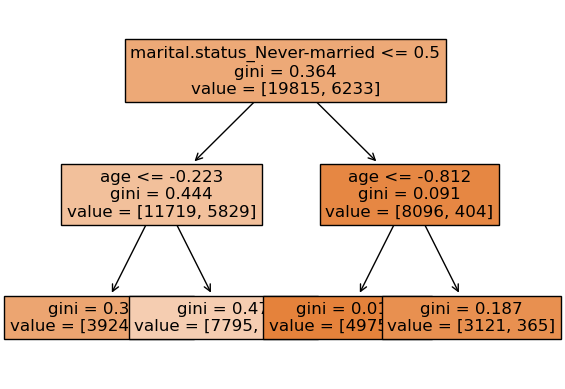

None

prediction [0.]


Tree 2


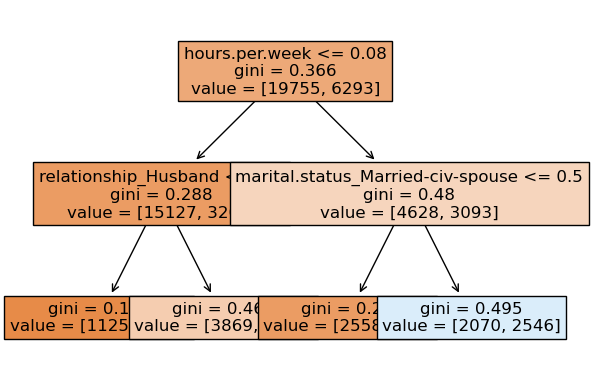

None

prediction [1.]


Tree 3


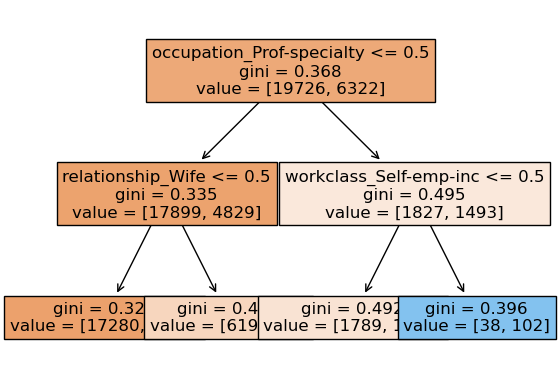

None

prediction [1.]


In [22]:
for i, tree in enumerate(
    pipe_rf_demo.named_steps["randomforestclassifier"].estimators_
):
    print("\n\nTree", i + 1)
    display(custom_plot_tree(tree, feature_names, fontsize=12))
    print("prediction", tree.predict(preprocessor.transform(test_example)))

### Some important hyperparameters:

- `n_estimators`: number of decision trees (higher = more complexity)
- `max_depth`: max depth of each decision tree (higher = more complexity)
- `max_features`: the number of features you get to look at each split (higher = more complexity)


### Random forests: number of trees (`n_estimators`) and the fundamental tradeoff 

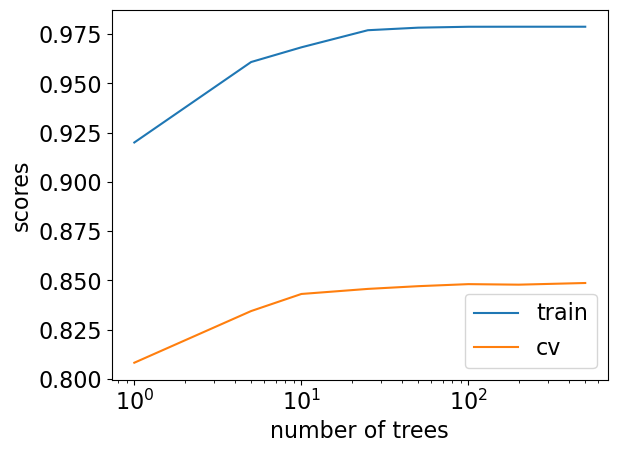

In [23]:
make_num_tree_plot(
    preprocessor, X_train, y_train, X_test, y_test, [1, 5, 10, 25, 50, 100, 200, 500]
) # User-defined function defined in code/plotting_functions.py 

#### Number of trees and fundamental trade-off

- Above: seems like we're beating the fundamental "tradeoff" by increasing training score and not decreasing validation score much.
- You'll often see a high training scores for in the context of random forests. That's normal. It doesn't mean that the model is overfitting. 
- While ensembles often offer improved performance, this benefit isn't always guaranteed.
- Always opting for more trees in a random forest is preferable, but we sometimes choose fewer trees for faster performance.


### Strengths and weaknesses

- Usually one of the best performing off-the-shelf classifiers without heavy tuning of hyperparameters
- Don't require scaling of data 
- Less likely to overfit 
- Slower than decision trees because we are fitting multiple trees but can easily parallelize training because all trees are independent of each other 
- In general, able to capture a much broader picture of the data compared to a single decision tree. 

### Weaknesses

- Require more memory 
- Hard to interpret
- Tend not to perform well on high dimensional sparse data such as text data


```{seealso}
There is also something called [`ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) where randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. 
[Source](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)
```

```{important}
Make sure to set the `random_state` for reproducibility. Changing the `random_state` can have a big impact on the model and the results due to the random nature of these models. Having more trees can get you a more robust estimate. 
```

```{seealso}
[The original random forests paper](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) by Leo Breiman. 
```

## ❓❓ Questions for you

### iClicker Exercise 11.1 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select the most accurate option below.**

- (A) Every tree in a random forest uses a different bootstrap sample of the training set.
- (B) To train a tree in a random forest, we first randomly select a subset of features. The tree is then restricted to only using those features.
- (C) The `n_estimators` hyperparameter of random forests should be tuned to get a better performance on the validation or test data.  
- (D) In random forests we build trees in a sequential fashion, where the current tree is dependent upon the previous tree.  
- (E) Let classifiers A, B, and C have training errors of 10%, 20%, and 30%, respectively. Then, the best possible training error from averaging A, B and C is 10%.

- Why do we create random forests out of random trees (trees where each stump only looks at a subset of the features, and the dataset is a bootstrap sample) rather than creating them out of regular decision trees?

<br><br><br><br>

## Gradient boosted trees [[video](https://youtu.be/EkFkY9QB2Hw)]

Another popular and effective class of tree-based models is gradient boosted trees. 

- No randomization.
- The key idea is combining many simple models called weak learners to create a strong learner. 
- They combine multiple shallow (depth 1 to 5) decision trees.  
- They build trees in a serial manner, where each tree tries to correct the mistakes of the previous one. 

### (Optional) Prediction in boosted regression trees

- Credit: Adapted from [CPSC 340 notes](https://www.students.cs.ubc.ca/~cs-340/L24.pdf)
- Gradient boosting starts with an ensemble of $k$ shallow decision trees. 
- For each example $i$, each shallow tree makes a continuous prediction: $\hat{y}_{i1}, \hat{y}_{i2}, \dots, \hat{y}_{ik}$
- The final prediction is sum of individual predictions: $\hat{y}_{i1} + \hat{y}_{i2} + \dots + \hat{y}_{ik}$
- Note that we do not use the average as we would with random forests because  
    - In boosting, each tree is not individually trying to predict the true $y_i$ value
    - Instead, each new tree tries to "fix" the prediction made by the old trees, so that sum is $y_i$

### (Optional) Fitting in boosted regression trees. 
Consider the following "gradient tree boosting" procedure:

```
Tree[1].fit(X,y)
y_hat = Tree[1].predict(X)
Tree[2].fit(X,y - y_hat)
y_hat = y_hat + Tree[2].predict(X)
Tree[3].fit(X,y - y_hat)
y_hat = y_hat + Tree[3].predict(X)
Tree[4].fit(X,y - y_hat)
y_hat = y_hat + Tree[4].predict(X)
```

- Each tree is trying to predict residuals (`y - y_hat`) of current prediction.
    - True label is 0.9, old prediction is 0.8, so I can improve `y_hat` by predicting 0.1.

<br><br>

We'll not go into the details. If you want to know more, here are some resources: 
- [UBC CPSC 340 Gradient Boosting notes](https://www.students.cs.ubc.ca/~cs-340/L24.pdf)
- [Gradient Boosted Decision Trees by Google Developer](https://developers.google.com/machine-learning/decision-forests/intro-to-gbdt)

We'll look at brief examples of using the following three gradient boosted tree models. 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/)
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html) 
- [CatBoost](https://catboost.ai/docs/concepts/python-quickstart.html)

### [XGBoost](https://xgboost.ai/about) 

- Not part of `sklearn` but has similar interface. 
- Install it in your conda environment: `conda install -c conda-forge xgboost`
- Supports missing values
- GPU training, networked parallel training
- Supports sparse data
- Typically better scores than random forests    

### [LightGBM](https://lightgbm.readthedocs.io/)

- Not part of `sklearn` but has similar interface. 
- Install it in your conda environment: `conda install -c conda-forge lightgbm`
- Small model size
- Faster 
- Typically better scores than random forests    

Main hyperparameters

### [CatBoost](https://catboost.ai/)

- Not part of `sklearn` but has similar interface. 
- Install it in your course conda environment: `conda install -c conda-forge catboost`
- Usually better scores but slower compared to `XGBoost` and `LightGBM`     

### Important hyperparameters

- `n_estimators` $\rightarrow$ Number of boosting rounds
- `learning_rate` $\rightarrow$ The learning rate of training
    - controls how strongly each tree tries to correct the mistakes of the previous trees
    - higher learning rate means each tree can make stronger corrections, which means more complex model 
- `max_depth` $\rightarrow$ `max_depth` of trees (similar to decision trees) 
- `scale_pos_weight` $\rightarrow$ Balancing of positive and negative weights

In our demo below, we'll just give equal weight to both classes because we are trying to optimize accuracy. But if you want to give more weight to class 1, for example, you can calculate the data imbalance ratio and set `scale_pos_weight` hyperparameter with that weight. 

In [24]:
ratio = np.bincount(y_train_num)[0] / np.bincount(y_train_num)[1]
ratio

3.1319796954314723

### Gradient boosting in `sklearn`

sklearn also has gradient boosting models. 

- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
- [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) and [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor)  (Inspired by LGBM, supports missing values)

Let's try out all these models. 

In [25]:
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier(class_weight="balanced", random_state=123)
)
pipe_xgb = make_pipeline(
    preprocessor,
    XGBClassifier(
        random_state=123, verbosity=0
    ),
)
pipe_lgbm = make_pipeline(
    preprocessor, LGBMClassifier(random_state=123, verbose=-1)
)

pipe_catboost = make_pipeline(
    preprocessor,
    CatBoostClassifier(verbose=0, random_state=123),
)

pipe_sklearn_histGB = make_pipeline(
    preprocessor,
    HistGradientBoostingClassifier(random_state=123),
)

pipe_sklearn_GB = make_pipeline(
    preprocessor,
    GradientBoostingClassifier(random_state=123),
)

classifiers = {
    "logistic regression": pipe_lr,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
    "sklearn_histGB": pipe_sklearn_histGB,
    "sklearn_GB": pipe_sklearn_GB,
}

ModuleNotFoundError: No module named 'catboost'

In [ ]:
import warnings

warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [ ]:
results = {}

In [ ]:
dummy = DummyClassifier()
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [ ]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train_num, return_train_score=True, scoring=scoring_metric
    )

In [ ]:
pd.DataFrame(results).T

**Some observations**
- Keep in mind all these results are with default hyperparameters
- Ideally we would carry out hyperparameter optimization for all of them and then compare the results. 
- We are using a particular scoring metric (accuracy in this case)
- We are scaling numeric features but it shouldn't matter for tree-based models
- Look at the standard deviation. Doesn't look very high. 
    - The scores look more or less stable. 

In [ ]:
pd.DataFrame(results).T

- Decision trees and random forests overfit
    - Other models do not seem to overfit much. 
- Fit times
    - Decision trees are fast but not very accurate
    - LightGBM is faster than decision trees and more accurate! 
    - CatBoost fit time is highest. 
    - There is not much difference between the validation scores of XGBoost, LightGBM, and CatBoost.
    - Among the best performing models, LightGBM is the fastest one!
- Scores times  
    - Prediction times are much smaller in all cases. 

<br><br>

### Which model should I use?

**Simple answer**
- Whichever gets the highest CV score making sure that you're not overusing the validation set.

**Interpretability**
- This is an area of growing interest and concern in ML.
- How important is interpretability for you? 
- In the next class we'll talk about interpretability of non-linear models. 


**Speed/code maintenance**
- Other considerations could be speed (fit and/or predict), maintainability of the code.

Finally, you could use all of them!

<br><br><br><br>

## Averaging 

Earlier we looked at a bunch of classifiers:

In [ ]:
classifiers.keys()

For this demonstration, let's get rid of sklearn's gradient boosting models and CatBoost because it's too slow. 

In [ ]:
del classifiers["sklearn_histGB"]
del classifiers["sklearn_GB"]
del classifiers["CatBoost"]

In [ ]:
classifiers.keys()

What if we use all the models in `classifiers` and let them vote during prediction time? 

In [ ]:
from sklearn.ensemble import VotingClassifier

averaging_model = VotingClassifier(
    list(classifiers.items()), voting="soft"
)  # need the list() here for cross-validation to work!

In [ ]:
from sklearn import set_config

set_config(display="diagram")  # global setting

In [ ]:
averaging_model

This `VotingClassifier` will take a _vote_ using the predictions of the constituent classifier pipelines.

Main parameter: `voting`
- `voting='hard'` 
    - it uses the output of `predict` and actually votes.
- `voting='soft'`
    - with `voting='soft'` it averages the output of `predict_proba` and then thresholds / takes the larger.

- The choice depends on whether you trust `predict_proba` from your base classifiers - if so, it's nice to access that information.

In [ ]:
averaging_model.fit(X_train, y_train_num);

- What happens when you `fit` a `VotingClassifier`?
    - It will fit all constituent models.    

```{note}
It seems sklearn requires us to actually call `fit` on the `VotingClassifier`, instead of passing in pre-fit models. This is an implementation choice rather than a conceptual limitation.
```

Let's look at particular test examples where `income` is ">50k" (y=1):

In [ ]:
test_g50k = (
    test_df.query("income == '>50K'")
    .sample(4, random_state=42)
    .drop(columns=["income"])
)
test_l50k = (
    test_df.query("income == '<=50K'")
    .sample(4, random_state=2)
    .drop(columns=["income"])
)

In [ ]:
averaging_model.classes_

What are the predictions given by the voting model? 

In [ ]:
data = {"y": 1, "Voting classifier": averaging_model.predict(test_g50k)}
pd.DataFrame(data)

For hard voting, these are the votes:

In [ ]:
r1 = {
    name: classifier.predict(test_g50k)
    for name, classifier in averaging_model.named_estimators_.items()
}
data.update(r1)
pd.DataFrame(data)

For soft voting, these are the scores:

In [ ]:
r2 = {
    name: classifier.predict_proba(test_g50k)[:, 1]
    for name, classifier in averaging_model.named_estimators_.items()
}

data.update(r2)
pd.DataFrame(data)

(Aside: the probability scores from `DecisionTreeClassifier` are pretty bad)

What's the prediction probability of the averaging model? Let's examine prediction probability of the first example from `test_g50k`. 

In [ ]:
averaging_model.predict_proba(test_g50k)[1]

It adds the prediction probabilities given by constituent models and divides the summation by the number of constituent models. 

In [ ]:
# Sum of probabilities for class 0 at index 1
sum_prob_ex1_class_0 = np.sum(
    [
        classifier.predict_proba(test_g50k)[1][0]
        for name, classifier in averaging_model.named_estimators_.items()
    ]
)
sum_prob_ex1_class_0

In [ ]:
# Sum of probabilities for class 1 at index 1
sum_prob_ex1_class_1 = np.sum(
    [
        classifier.predict_proba(test_g50k)[1][1]
        for name, classifier in averaging_model.named_estimators_.items()
    ]
)
sum_prob_ex1_class_1

In [ ]:
n_constituents = len(averaging_model.named_estimators_)
n_constituents

In [ ]:
sum_prob_ex1_class_0 / n_constituents, sum_prob_ex1_class_1 / n_constituents

In [ ]:
averaging_model.predict_proba(test_g50k)[1]

They match! 

Let's see how well this model performs.

In [ ]:
averaging_model.predict_proba(test_g50k)[2]

In [ ]:
results["Voting"] = mean_std_cross_val_scores(
    averaging_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [ ]:
pd.DataFrame(results).T

It appears that here we didn't do much better than our best classifier :(. 

Let's try removing decision tree classifier. 

In [ ]:
classifiers_ndt = classifiers.copy()
del classifiers_ndt["decision tree"]
averaging_model_ndt = VotingClassifier(
    list(classifiers_ndt.items()), voting="soft"
)  # need the list() here for cross_val to work!

results["Voting_ndt"] = mean_std_cross_val_scores(
    averaging_model_ndt,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metric,
)

In [ ]:
pd.DataFrame(results).T

Still the averaging scores are not better than the best performing model. 

- It didn't happen here but how could the average do better than the best model???
  - From the perspective of the best estimator (in this case CatBoost), why are you adding on worse estimators??


Here's how this can work:

| Example | log reg    | rand forest    | cat boost    | Averaged model |
|--------|--------|--------|---------|---------------|
|  1     | ✅    |   ✅    | ❌     | ✅✅❌=>✅  |
|  2     | ✅    |   ❌    | ✅     | ✅❌✅=>✅  |
|  3     | ❌    |   ✅    | ✅     | ❌✅✅=>✅  |


- In short, as long as the different models make different mistakes, this can work.
- Probably in our case, we didn't have enough diversity. 

Why not always do this?

1. `fit`/`predict` time.
2. Reduction in interpretability.
3. Reduction in code maintainability (e.g. Netflix prize).

### What kind of estimators can we combine? 

- You can combine 
    - completely different estimators, or similar estimators.
    - estimators trained on different samples.
    - estimators with different hyperparameter values.

## ❓❓ Questions for you

- Is it possible to get better than the best performing model using averaging. 
- Is random forest is an averaging model? 

<br><br><br><br>

## Stacking 


- Another type of ensemble is stacking.
- Instead of averaging the outputs of each estimator, use their outputs as _inputs to another model_.
- By default for classification, it uses logistic regression.
  - We don't need a complex model here necessarily, more of a weighted average.
  - The features going into the logistic regression are the classifier outputs, _not_ the original features!
  - So the number of coefficients = the number of base estimators!

In [ ]:
from sklearn.ensemble import StackingClassifier

The code starts to get too slow here; so we'll remove CatBoost. 

In [ ]:
stacking_model = StackingClassifier(list(classifiers.items()))

In [ ]:
stacking_model.fit(X_train, y_train);

What's going on in here? 

- It is doing cross-validation by itself by default (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html))

> Note that estimators_ are fitted on the full X while final_estimator_ is trained using cross-validated predictions of the base estimators using cross_val_predict.

Here is the input features (X) to the meta-model:

In [ ]:
valid_sample_df = train_df.sample(10, random_state=12)
valid_sample_X = valid_sample_df.drop(columns=["income"])
valid_sample_y = valid_sample_df['income']

In [ ]:
# data = {}

In [ ]:
# r4 = {
#     name + "_proba": pipe.predict_proba(valid_sample_X)[:, 1]
#     for (name, pipe) in stacking_model.named_estimators_.items()
# }
# data['y'] = valid_sample_y
# data.update(r4)
# pd.DataFrame(data)

- Our meta-model is logistic regression (which it is by default).
- Let's look at the learned coefficients. 

In [ ]:
pd.DataFrame(
    data=stacking_model.final_estimator_.coef_.flatten(),
    index=classifiers.keys(),
    columns=["Coefficient"],
).sort_values("Coefficient", ascending=False)

In [ ]:
stacking_model.final_estimator_.intercept_

- It seems that the LightGBM is being trusted the most. 
- It's funny that it has given a negative coefficient to decision tree. 
    - Our meta model doesn't trust decision tree model. 
    - In fact, if the decision tree model says class >=50k, the model is likely to predict the opposite 🙃

In [ ]:
stacking_model.predict(test_l50k)

In [ ]:
stacking_model.predict_proba(test_g50k)

(This is the `predict_proba` from meta model logistic regression)

Let's see how well this model performs.

In [ ]:
results["Stacking"] = mean_std_cross_val_scores(
    stacking_model, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [ ]:
pd.DataFrame(results).T

- The situation here is a bit mind-boggling.
- On each fold of cross-validation it is doing cross-validation.
- This is really loops within loops within loops within loops...

- We can also try a different final estimator:
- Let's `DecisionTreeClassifier` as a final estimator. 

In [ ]:
stacking_model_tree = StackingClassifier(
    list(classifiers.items()), final_estimator=DecisionTreeClassifier(max_depth=3)
)

The results might not be very good. But we can visualize the tree:

In [ ]:
stacking_model_tree.fit(X_train, y_train);

In [ ]:
custom_plot_tree(stacking_model_tree.final_estimator_, 
                 feature_names=list(classifiers.keys()),
                 class_names=['"<=50K"', '">50K"'],
                 impurity=False,
                 fontsize=6)

#### An effective strategy

- Randomly generate a bunch of models with different hyperparameter configurations, and then stack all the models.

- What is an advantage of ensembling multiple models as opposed to just choosing one of them?
    - You may get a better score.
- What is a disadvantage of ensembling multiple models as opposed to just choosing one of them?
    - Slower, more code maintenance issues.

There are equivalent regression models for all of these:

- `RandomForestClassifier` $\rightarrow$ [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- `LGBMClassifier` $\rightarrow$ [`LGBMRegressor`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)
- `XGBClassifier` $\rightarrow$ [`XGBRegressor`](https://xgboost.readthedocs.io/en/latest/python/python_api.html)
- `CatBoostClassifier` $\rightarrow$ `CatBoostRegressor`
- `VotingClassifier` $\rightarrow$ [`VotingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html)
- `StackingClassifier` $\rightarrow$ [`StackingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html)

Read documentation of each of these.

<br><br><br><br>

## Summary 

- You have a number of models in your toolbox now.  
- Ensembles are usually pretty effective.
  - Tree-based models are particularly popular and effective on a wide range of problems. 
  - But they trade off code complexity and speed for prediction accuracy.
  - Don't forget that hyperparameter optimization multiplies the slowness of the code!
- Stacking is a bit slower than voting, but generally higher accuracy.
  - As a bonus, you get to see the coefficients for each base classifier.
- All the above models have equivalent regression models.   

#### Relevant papers

- [Fernandez-Delgado et al. 2014](http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf) compared 179 classifiers on 121 datasets:
    - First best class of methods was Random Forest and second best class of methods was (RBF) SVMs.

- If you like to read original papers [here](https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf) is the original paper on Random Forests by Leo Breiman. 
- [XGBoost, LightGBM or CatBoost — which boosting algorithm should I use?](https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc)